In [1]:
import import_ipynb, torch, torchaudio, random, import_ipynb, os
from sklearn.preprocessing import StandardScaler
import numpy as np
# from train_test_split import *
import pandas as pd
from data import *
import torchaudio.functional as F
import matplotlib.pyplot as plt
from IPython.display import Audio

importing Jupyter notebook from data.ipynb


In [3]:
# x_train = torch.load('data_train.pt')
# x_test = torch.load('data_test.pt')
# y_train = torch.load('label_train.pt')
# y_test = torch.load('label_test.pt')

## Scaler

In [15]:
#feature scalling
def StandardScalling(x_train, x_test):
    scaler = StandardScaler()

    N,H,W = x_train.shape # N: number of sample, W: weight, H: height
    # standard scale use for only 1-D array
    x_train = np.reshape(x_train, (N, -1))
    x_train = scaler.fit_transform(x_train)
    x_train = np.reshape(x_train, (N,H,W))

    N,H,W = x_test.shape # N: number of sample, W: weight, H: height
    # standard scale use for only 1-D array
    x_test = np.reshape(x_test, (N, -1))
    x_test = scaler.fit_transform(x_test)
    x_test = np.reshape(x_test, (N,H,W))    

    return x_train, x_test


In [1]:
# test_train, test_test = StandardScalling(x_train,x_test)


## Augmentation

### AWGN - Additive White Gaussian Noise

In [1]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate normally distributed (Gaussian) noises
    # one for each waveform and multiple (i.e. wave_len*multiples noises)
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product 
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms

In [2]:
def augment_waveforms(waveforms, features, emotions, multiples):
    # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
    emotion_count = 0
    # keep track of how many augmented samples we've added
    added_count = 0
    # convert emotion array to list for more efficient appending
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1
        
        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)
    
    return features, emotions

### Background noise

In [4]:
sample = pd.read_csv('processed_label_data.csv')
sample.path[0]

'c:\\Users\\hoang\\Pojects\\audio2emotion\\IEMOCAP_full_release\\Session1\\sentences\\mfcc\\Ses01F_impro01\\Ses01F_impro01_F000.pt'

In [3]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [4]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [11]:
path = 'C:\\Users\\hoang\\Pojects\\audio2emotion\\IEMOCAP_full_release\\Session1\\sentences\\wav\\Ses01F_impro01\\Ses01F_impro01_F000.wav'
path_ = 'C:\\Users\\hoang\\Pojects\\audio2emotion\\IEMOCAP_full_release\\Session1\\sentences\\mfcc\\Ses01F_impro01\\Ses01F_impro01_F000.pt'
noise_path = 'C:\\Users\\hoang\\Pojects\\audio2emotion\\IEMOCAP_full_release\\Session1\\sentences\\wav\\Ses01F_impro01\\Ses01F_impro01_F002.wav'

In [6]:
waveform1, sample_rate = torchaudio.load(path, channels_first=False)

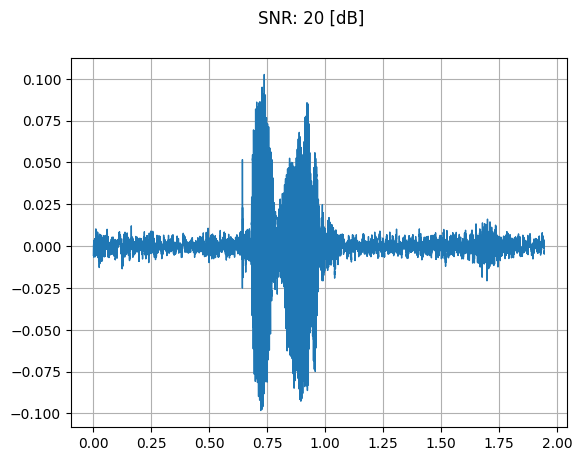

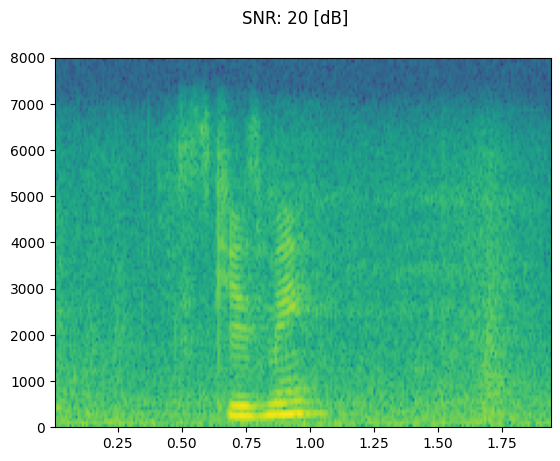

: 

In [21]:
speech, _ = torchaudio.load(path)
noise, _ = torchaudio.load(path)
noise = noise[:, : speech.shape[1]]

snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(speech, noise, snr_dbs)

snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0:1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### split sample for more 1807 positive sample and 1325 neutral sample

In [2]:
#add time mask for sample
def split_augmentation(path, file):
    time_mask = torch.zeros((2,40,50))
    sample = torch.load(path)
    start_time = random.randint(0,749)
    sample[:,:,start_time:start_time+50] = time_mask
    torch.save(sample, file)

In [3]:
#add more sample label neutral and positive to have same samples of categories
def balance_data():    
    root = os.path.join(link_to_data(),'IEMOCAP_full_release\Session0')
    df = pd.read_csv('processed_shape_data.csv')
    df_neu = df.loc[df.neutral == 1]
    df_neu = df_neu.sample(frac=1).reset_index()
    for index in range(1325):
        file = os.path.join(root,'neutral','sample'+str(index)+'.pt')
        split_augmentation(df_neu.path[index],file)
        new_row = {'sessionID':'Session0'+str(index),'labels':'neu_','positive':0,'neutral':1,'negative':0,'path':file}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df_pos = df.loc[df.positive == 1]
    df_pos = df_pos.sample(frac=1).reset_index()
    for index in range(1807):
        random_ = random.randint(0,df_pos.shape[0]-1)
        file = os.path.join(root,'positive','sample'+str(index)+'.pt')
        split_augmentation(df_pos.path[random_],file)
        new_row = {'sessionID':'Session0'+str(index),'labels':'pos_','positive':1,'neutral':0,'negative':0,'path':file}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv('processed_shape_data.csv',index = False)

In [4]:
balance_data()